In [7]:

# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import pandas as pd
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision import transforms, datasets
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from sklearn.utils import shuffle
from PIL import Image
from glob import glob


import matplotlib.pyplot as plt
# %matplotlib inline

import warnings
warnings.filterwarnings("ignore")



# GPU availability checking

In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print(device)

cuda:0


# Plot some images of the brain MRI scans


In [29]:

import cv2

data_path = "/kaggle/input/mri-4-way-dataset/mri dataset"
#list of images with no tumors
no_tumour = os.listdir(data_path + '/No/')
#list of image with tumors
gilom = os.listdir(data_path + '/G/')

mening = os.listdir(data_path + '/M/')

pituit = os.listdir(data_path + '/P/')

print(f'There are {len(no_tumour)} MRI scans of brains with no tumor')
print(f'There are {len(gilom)} MRI scans of brains with G tumor')

print(f'There are {len(mening)} MRI scans of brains with M tumor')
print(f'There are {len(pituit)} MRI scans of brains with P tumor')

There are 2100 MRI scans of brains with no tumor
There are 2100 MRI scans of brains with G tumor
There are 2100 MRI scans of brains with M tumor
There are 2100 MRI scans of brains with P tumor


# Check the size of some images

(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(239, 211, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(225, 225, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)


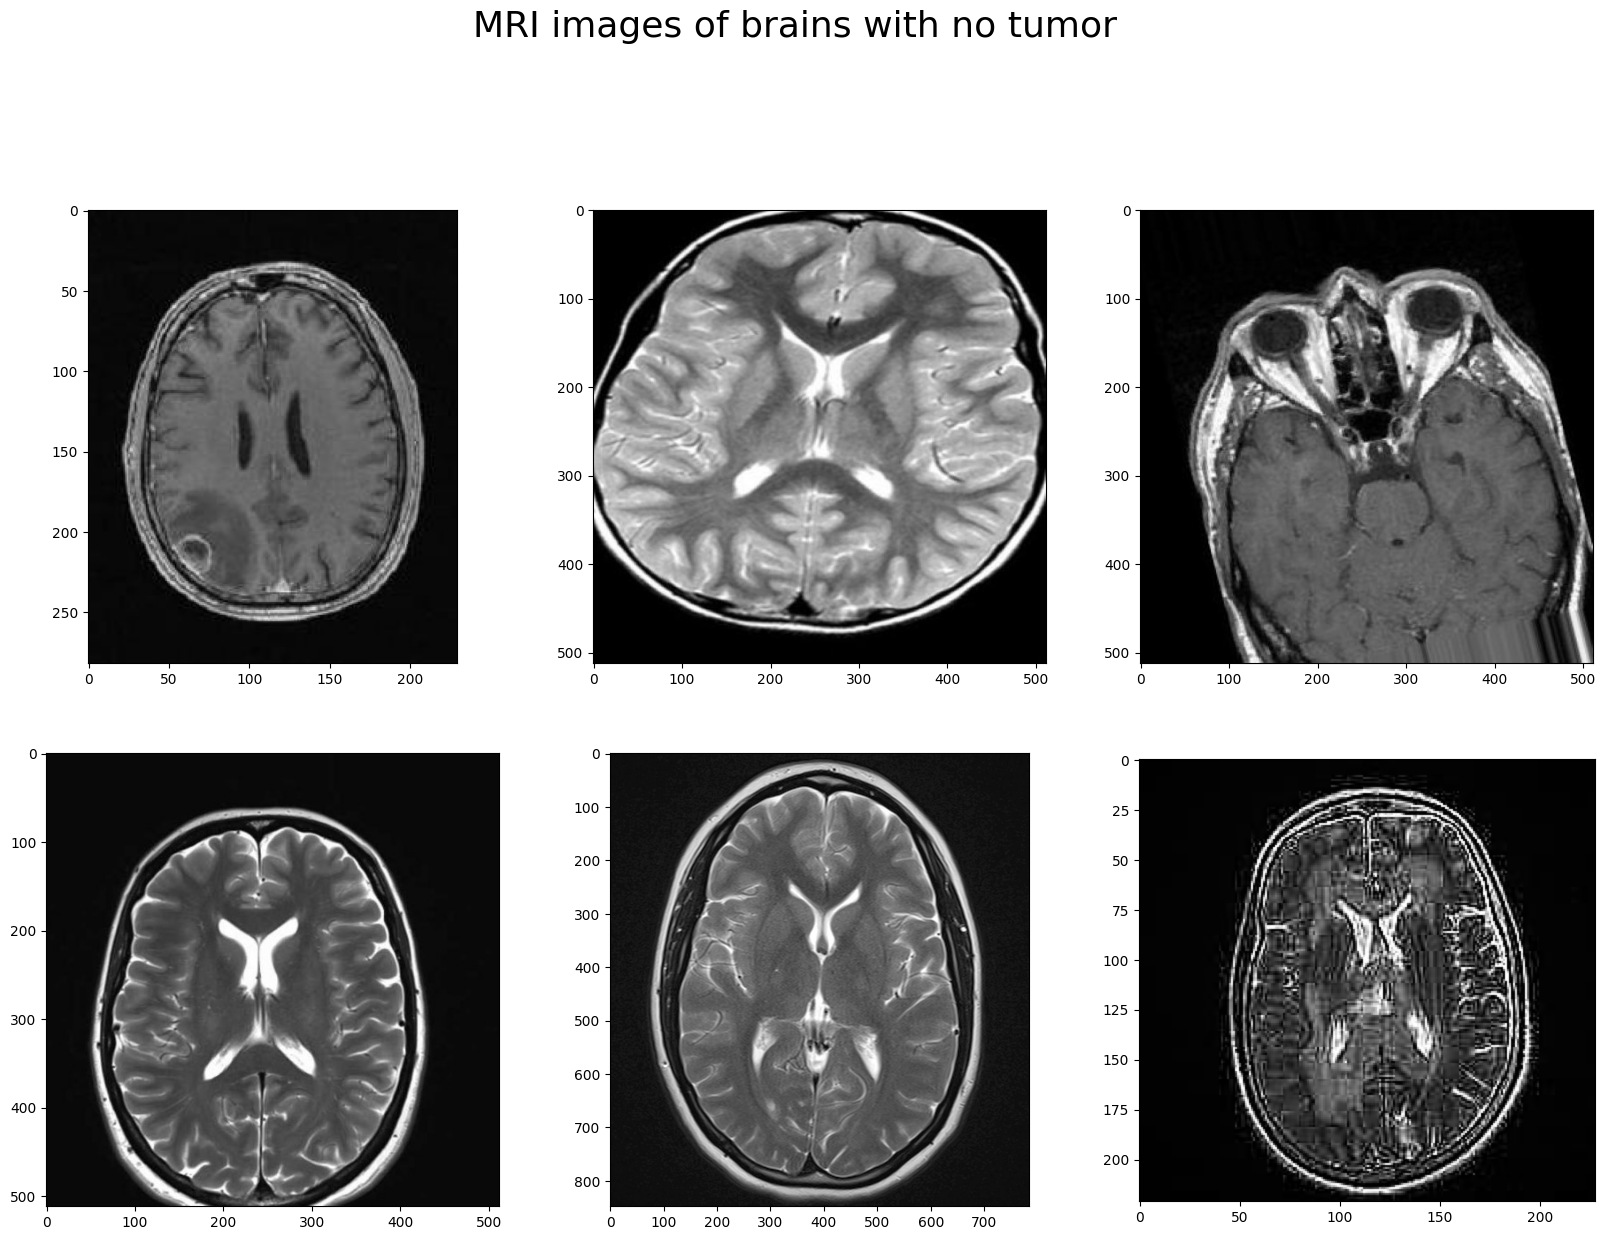

In [10]:
#Check the size of some images: all random sizes (which requires reshaping later)
rnd = [0, 10, 7, 8, 15]     #GILOMA
for i in range(len(rnd)):
    img0 = cv2.imread(data_path + '/G/'+ gilom[rnd[i]])
    print(img0.shape)

#Check the size of some images: all random sizes (which requires reshaping later)
rnd = [0, 10, 7, 8, 15]     #MENING
for i in range(len(rnd)):
    img0 = cv2.imread(data_path + '/M/'+ mening[rnd[i]])
    print(img0.shape)

#Check the size of some images: all random sizes (which requires reshaping later)
rnd = [0, 10, 7, 8, 15]     #PITUIT
for i in range(len(rnd)):
    img0 = cv2.imread(data_path + '/P/'+ pituit[rnd[i]])
    print(img0.shape)

#plot some images of brain MRI with no tumor
fig = plt.figure(figsize=(20,20))
for i in range(6):
    plt.subplot(3, 3, i+1)
    img = cv2.imread(data_path+'/No/'+ no_tumour[i])
    plt.imshow(img)
plt.suptitle("MRI images of brains with no tumor",fontsize=26)
plt.show()

# MRI dataset loader

In [11]:


class BrainMRI(Dataset):

    def __init__(self,data_dir,reshape=True,height=128,width=128):
        self.dataDirectory = data_dir
        self.no_class = glob(data_dir+'/No/*')
        self.g_class = glob(data_dir+'/G/*')
        self.m_class = glob(data_dir+'/M/*')
        self.p_class = glob(data_dir+'/P/*')


        self.height = height
        self.width = width
        self.reshape=reshape

        labels = [0 for i in range(len(self.no_class))]
        labels += [1 for i in range(len(self.g_class))]
        labels += [2 for i in range(len(self.m_class))]
        labels += [3 for i in range(len(self.p_class))]


        image_links = self.no_class + self.g_class + self.m_class + self.p_class
        self.dataframe = pd.DataFrame({
            'image':image_links,
            'labels': labels
        })

        self.dataframe = shuffle(self.dataframe)
        self.dataframe.reset_index(inplace=True,drop=True)

    def __len__(self):
        return len(self.no_class)+len(self.g_class) + len(self.m_class)+len(self.p_class)

    def __getitem__(self,idx):

        image_list = self.dataframe['image'][idx]
        label_list = self.dataframe['labels'][idx]

        if type(image_list) == str:
            image_list = [image_list]

        if not isinstance(label_list,np.int64):
            label_list = label_list.values

        image_array = []
        for image in image_list:
            image = Image.open(image).convert("L")
            if self.reshape:
                image = image.resize((self.height,self.width))

            array = np.asarray(image)
            array = array.reshape(self.height,self.width)
            image_array.append(array)

        return [torch.tensor(image_array,device=device),torch.tensor(label_list,device=device)]

    def __repr__(self):
        return str(self.dataframe.head(10))

df = BrainMRI(data_path)

df

                                               image  labels
0  /kaggle/input/mri-4-way-dataset/mri dataset/P/...       3
1  /kaggle/input/mri-4-way-dataset/mri dataset/G/...       1
2  /kaggle/input/mri-4-way-dataset/mri dataset/G/...       1
3  /kaggle/input/mri-4-way-dataset/mri dataset/P/...       3
4  /kaggle/input/mri-4-way-dataset/mri dataset/M/...       2
5  /kaggle/input/mri-4-way-dataset/mri dataset/G/...       1
6  /kaggle/input/mri-4-way-dataset/mri dataset/No...       0
7  /kaggle/input/mri-4-way-dataset/mri dataset/G/...       1
8  /kaggle/input/mri-4-way-dataset/mri dataset/No...       0
9  /kaggle/input/mri-4-way-dataset/mri dataset/G/...       1

# dataset format checking

In [12]:
#quick check of the format of the dataset
img_train, target = df[0]
img_train.shape, img_train, target.shape, target

(torch.Size([1, 128, 128]),
 tensor([[[55, 20, 24,  ..., 23, 21, 54],
          [44,  9, 12,  ..., 13,  9, 44],
          [48, 14, 18,  ..., 17, 13, 47],
          ...,
          [76, 58, 67,  ..., 60, 35, 59],
          [42, 13, 26,  ..., 15,  8, 41],
          [72, 38, 40,  ..., 40, 38, 70]]], device='cuda:0', dtype=torch.uint8),
 torch.Size([]),
 tensor(3, device='cuda:0'))

# CNN model

In [13]:

"""# CNN model

This model is a custom model finalized by trial and error.
"""

class CNN_BrainMRI(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32, 3, 1)
        self.conv2 = nn.Conv2d(32,16, 2, 1)
        self.mxpool = nn.MaxPool2d(2,2)
        self.flat = nn.Flatten()
        self.conv_total = nn.Sequential(
            self.conv1,
            self.mxpool,
            self.conv2,
            self.mxpool
        )
        #Why 15376? See the shape-tracing section below
        self.linear1 = nn.Linear(15376,64)
        self.linear2 = nn.Linear(64,4)

    def forward(self,x):
        x = F.relu(self.conv_total(x))
        x = self.flat(x)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)

        return F.log_softmax(x, dim=1)

model1 = CNN_BrainMRI()
model1.to(device)

CNN_BrainMRI(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(2, 2), stride=(1, 1))
  (mxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (conv_total): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 16, kernel_size=(2, 2), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear1): Linear(in_features=15376, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=4, bias=True)
)

# model training

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters())

epochs = 16
batch_size = 32
loss_list = []
correct_list = []
for epoch in range(epochs):
    total_loss = 0
    trn_corr = 0
    for n in range(len(df)//batch_size):
        data,target = df[n*batch_size:(n+1)*batch_size]
        data = data.view(batch_size,1,128,128)
        #Perform the prediction
        ypred = model1(data.float())
        loss = criterion(ypred,target)
        total_loss +=loss
        #Tally the number of correct predictions
        y_pred_val = torch.max(ypred.data, 1)[1]
        batch_corr = (y_pred_val == target).sum()
        trn_corr += batch_corr
        #Training steps
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_list.append(total_loss)
    correct_list.append(trn_corr)
    if epoch%4 == 0:
        print(f'Epochs: {epoch} Loss: {total_loss/n}')

#save the trained model
torch.save(model1.state_dict(), 'CNN_BrainMRI_tumor_classification.pt')



Epochs: 0 Loss: 0.04182807356119156
Epochs: 4 Loss: 0.02930106781423092
Epochs: 8 Loss: 0.005583108402788639
Epochs: 12 Loss: 0.01521342247724533


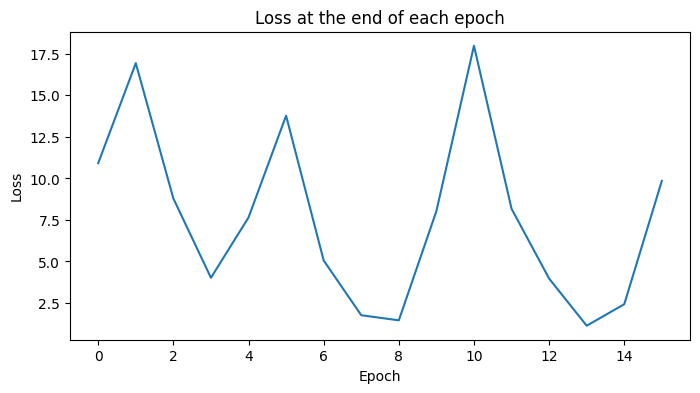

In [17]:
#get rid of the 'requires_grad' in the entries of loss_list
for i in range(len(loss_list)):
    loss_list[i] = loss_list[i].detach().cpu().numpy()
#plotting the loss per epoch
fig = plt.figure(figsize=(8,4))
plt.plot(list(range(epochs)),loss_list)
plt.title("Loss at the end of each epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Evalution section

The model accuracy is 0.99


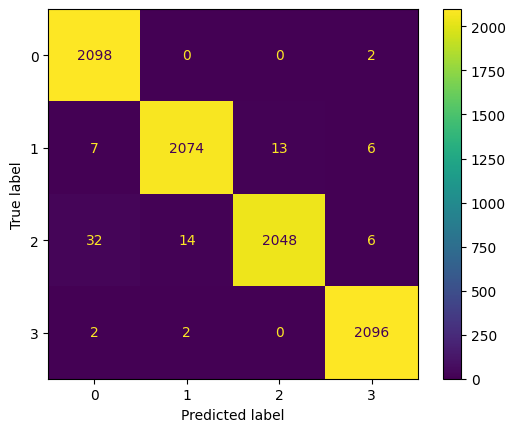

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import torch

preds = []
targets = []

for i in range(len(df)):
    data, target = df[i]
    data = data.view(1, 1, 128, 128)  # Adjust according to your model's input shape
    pred = model1(data.float())
    pred = torch.argmax(pred, dim=1)

    # Ensure pred is moved to CPU, converted to numpy, and has at least one dimension
    pred_numpy = pred.cpu().numpy()
    preds.append(np.expand_dims(pred_numpy, axis=0) if pred_numpy.ndim == 0 else pred_numpy)

    # Handle target similarly
    if torch.is_tensor(target):
        target_numpy = target.cpu().numpy()
    else:
        # Assuming target is a scalar or already a NumPy array
        target_numpy = np.array([target])
    targets.append(np.expand_dims(target_numpy, axis=0) if target_numpy.ndim == 0 else target_numpy)

# Concatenate all items for preds and targets
preds_np = np.concatenate(preds, axis=0)
targets_np = np.concatenate(targets, axis=0)

# Calculate accuracy
acc = accuracy_score(targets_np, preds_np)
print(f'The model accuracy is {acc:.2f}')

# Generate and display confusion matrix
cm = confusion_matrix(targets_np, preds_np)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


# Sample Image Prediction

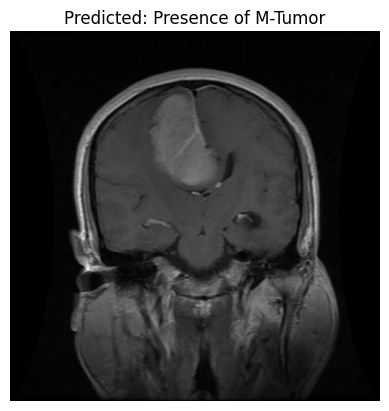

In [28]:

# mama margaya
import numpy as np
import matplotlib.pyplot as plt

# Function to load and preprocess a single MRI image
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert("L")  # Convert to grayscale
    image = image.resize((128, 128))  # Resize to match model input size
    image_array = np.asarray(image)  # Convert to numpy array
    image_tensor = torch.tensor(image_array, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    return image_tensor

# Function to predict tumor presence in a single MRI image
def predict_tumor_presence(model, image_tensor):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        output = model(image_tensor.to(device))  # Forward pass
        prediction = torch.argmax(output, dim=1).item()  # Get predicted class index
    return prediction

# Function to display prediction
def display_prediction(image_path, prediction):
    mapping = {0: 'No tumor', 1: 'Presence of G-Tumor' , 2: 'Presence of M-Tumor' , 3: 'Presence of P-Tumor'}
    plt.imshow(Image.open(image_path), cmap='gray')
    plt.title(f'Predicted: {mapping[prediction]}')
    plt.axis('off')
    plt.show()

# Path to the single MRI image you want to test
single_image_path = "/kaggle/input/mri-4-way-dataset/mri dataset/M/Tr-me_0532.jpg"

# Load and preprocess the single MRI image
image_tensor = load_and_preprocess_image(single_image_path)

# Predict tumor presence
prediction = predict_tumor_presence(model1, image_tensor)

# Display prediction
display_prediction(single_image_path, prediction)